## License 

Copyright 2019 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

# All models are wrong, but ... why is my model wrong? 
**Part 2: Residual analysis for model debugging**

"All models are wrong but some are useful" -- George Box, 1978

This notebook ... 

#### Python imports 

In [1]:
import numpy as np                   # array, vector, matrix calculations
import os                            # file-handling
import pandas as pd                  # DataFrame handling
import shap                          # for consistent, signed variable importance measurements
import xgboost as xgb                # gradient boosting machines (GBMs)


import matplotlib.pyplot as plt      # plotting
import seaborn as sns

pd.options.display.max_columns = 999 # enable display of all dataframe columns in notebook

# enables display of plots in notebook
# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

np.random.seed(12345)                # set random seed for reproducibility

/home/patrickh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [2]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [3]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [4]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. Investigate pair-wise Pearson correlations for DEFAULT_NEXT_MONTH

Monotonic relationships are much easier to explain to colleagues, bosses, customers, and regulators than more complex, non-monotonic relationships and monotonic relationships may also prevent overfitting and excess error due to variance for new data.

To train a transparent monotonic classifier, contraints must be supplied to XGBoost that determine whether the learned relationship between an input variable and the prediction target `DEFAULT_NEXT_MONTH` will be increasing for increases in an input variable or decreasing for increases in an input variable. Pearson correlation provides a linear measure of the direction of the relationship between each input variable and the target. If the pair-wise Pearson correlation between an input and `DEFAULT_NEXT_MONTH` is positive, it will be constrained to have an increasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. If the pair-wise Pearson correlation is negative, the input will be constrained to have a decreasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. 

Constrainsts are supplied to XGBoost in the form of a Python tuple with length equal to the number of inputs. Each item in the tuple is associated with an input variable based on its index in the tuple. The first constraint in the tuple is associated with the first variable in the training data, the second constraint in the tuple is associated with the second variable in the training data, and so on. The constraints themselves take the form of a 1 for a positive relationship and a -1 for a negative relationship.

#### Calculate Pearson correlation

The Pandas `.corr()` function returns the pair-wise Pearson correlation between variables in a Pandas DataFrame. Because `DEFAULT_NEXT_MONTH` is the last column in the `data` DataFrame, the last column of the Pearson correlation matrix indicates the direction of the linear relationship between each input variable and the prediction target, `DEFAULT_NEXT_MONTH`. According to the calculated values, as a customer's balance limit (`LIMIT_BAL`), bill amounts (`BILL_AMT1`-`BILL_AMT6`), and payment amounts (`PAY_AMT1`-`PAY_AMT6`) increase, their probability of default tends to decrease. However as a customer's number of late payments increase (`PAY_0`, `PAY_2`-`PAY6`), their probability of default usually increases. In general, the Pearson correlation values make sense, and they will be used to ensure that the modeled relationships will make sense as well. (Pearson correlation values between the target variable, DEFAULT_NEXT_MONTH, and each input variable are displayed directly below.)

In [5]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1] 

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


#### Create tuple of monotonicity constraints from Pearson correlation values

The last column of the Pearson correlation matrix is transformed from a numeric column in a Pandas DataFrame into a Python tuple of `1`s and `-1`s that will be used to specifiy monotonicity constraints for each input variable in XGBoost. If the Pearson correlation between an input variable and `DEFAULT_NEXT_MONTH` is positive, a positive montonic relationship constraint is specified for that variable using `1`. If the correlation is negative, a negative monotonic constraint is specified using `-1`. (Specifying `0` indicates that no constraints should be used.) The resulting tuple will be passed to XGBoost when the GBM model is trained.

In [6]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

## 3. Train XGBoost with monotonicity constraints

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable, but here the `monotone_constraints` tuning parameter is used to enforce monotonicity between inputs and the prediction for `DEFAULT_NEXT_MONTH`. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, GBM variable importance is calculated and displayed. GBM variable importance is a global measure of the overall impact of an input variable on the GBM model predictions. Global variable importance values give an indication of the magnitude of a variable's contribution to model predictions for all observations. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

#### Split data into training and test sets for early stopping

The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [7]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.70    # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


#### Train XGBoost GBM classifier
To train an XGBoost classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. Many XGBoost tuning parameters must be specified as well. Typically a grid search would be performed to identify the best parameters for a given modeling task. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Notice that the monotonicity constraints are passed to XGBoost using the `monotone_constraints` parameter. Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test area under the curve (AUC) statistic fails to increase for 50 iterations.

In [8]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'logloss',                   # stop training based on
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 12345                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      62,                       # shap currently does not account for early stopping, pre-determined
                      evals=watchlist,          # use watchlist for early stopping 
                      verbose_eval=True)        # display iteration progress


[0]	train-logloss:0.517487	eval-logloss:0.51404
[1]	train-logloss:0.504097	eval-logloss:0.500144
[2]	train-logloss:0.49331	eval-logloss:0.489053
[3]	train-logloss:0.48449	eval-logloss:0.480157
[4]	train-logloss:0.476882	eval-logloss:0.472429
[5]	train-logloss:0.470593	eval-logloss:0.46606
[6]	train-logloss:0.465221	eval-logloss:0.460639
[7]	train-logloss:0.460893	eval-logloss:0.456227
[8]	train-logloss:0.456987	eval-logloss:0.452346
[9]	train-logloss:0.453662	eval-logloss:0.449056
[10]	train-logloss:0.450854	eval-logloss:0.446329
[11]	train-logloss:0.448211	eval-logloss:0.443774
[12]	train-logloss:0.445944	eval-logloss:0.441601
[13]	train-logloss:0.444034	eval-logloss:0.439837
[14]	train-logloss:0.442334	eval-logloss:0.438174
[15]	train-logloss:0.440674	eval-logloss:0.436801
[16]	train-logloss:0.439326	eval-logloss:0.435491
[17]	train-logloss:0.438064	eval-logloss:0.434513
[18]	train-logloss:0.436879	eval-logloss:0.433658
[19]	train-logloss:0.4357	eval-logloss:0.432662
[20]	train-loglo

# 4. Calculate and Analyze  LogLoss Residuals

#### Score test data and calculate logloss residuals

In [9]:
test_yhat = test.copy(deep=True)
test_yhat.reset_index(drop=True, inplace=True)

yhat = 'p_DEFAULT_NEXT_MONTH'
test_yhat[yhat] = pd.DataFrame(xgb_model.predict(xgb.DMatrix(test[X]))) 
test_yhat['r_DEFAULT_NEXT_MONTH'] = -test_yhat[y]*np.log(test_yhat['p_DEFAULT_NEXT_MONTH']) -\
                                     (1 - test_yhat[y])*np.log(1 - test_yhat['p_DEFAULT_NEXT_MONTH'])

# check that logloss is calculated correctly
# should match eval-logloss above
print('Mean logloss residual: %.6f' % test_yhat['r_DEFAULT_NEXT_MONTH'].mean())

Mean logloss residual: 0.426156


#### Plot logloss residuals

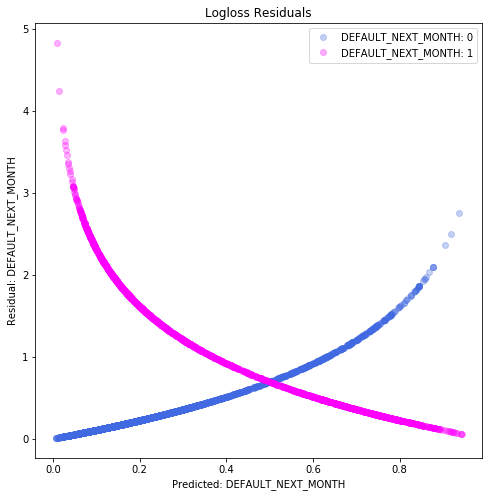

In [10]:
groups = test_yhat.groupby('DEFAULT_NEXT_MONTH') # define groups
fig, ax_ = plt.subplots(figsize=(8, 8))          # initialize figure

plt.xlabel('Predicted: DEFAULT_NEXT_MONTH')
plt.ylabel('Residual: DEFAULT_NEXT_MONTH')

# plot groups with appropriate color
color_list = ['royalblue', 'magenta'] 
c_idx = 0
for name, group in groups:
    ax_.plot(group.p_DEFAULT_NEXT_MONTH, group.r_DEFAULT_NEXT_MONTH, label=' '.join(['DEFAULT_NEXT_MONTH:', str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

_ = ax_.legend(loc=1) # legend
_ = plt.title('Logloss Residuals')

#### Examine high logloss individuals

In [11]:
test_yhat_sorted = test_yhat.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).reset_index(drop=True)
test_yhat_sorted.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,983,500000,1,1,2,36,-2,-2,-2,-2,-2,-2,45106,81264,18122,27229,21462,27911,81690,18225,27365,21570,28050,17397,1,0.008015,4.826454
1,25772,350000,2,1,1,33,0,-1,-1,-1,-1,-1,82964,68532,17926,17966,30741,31088,68940,18018,18058,30897,31244,88461,1,0.014396,4.240807
2,11571,200000,1,2,2,30,-2,-2,-2,-2,-2,-2,48492,49934,24753,123439,132269,129224,20294,24891,125171,17816,26269,4349,1,0.022704,3.785196
3,2561,310000,2,1,2,32,-2,-2,-2,-2,-2,-2,20138,8267,65993,8543,1695,750,8267,66008,8543,1695,750,7350,1,0.023283,3.760035
4,16209,360000,2,1,1,35,-2,-1,0,-1,-1,-1,94657,34529,106276,73331,7759,31840,45000,100000,73427,7759,31840,12577,1,0.026504,3.630469


#### Residuals plotted by important variables

`PAY_0`

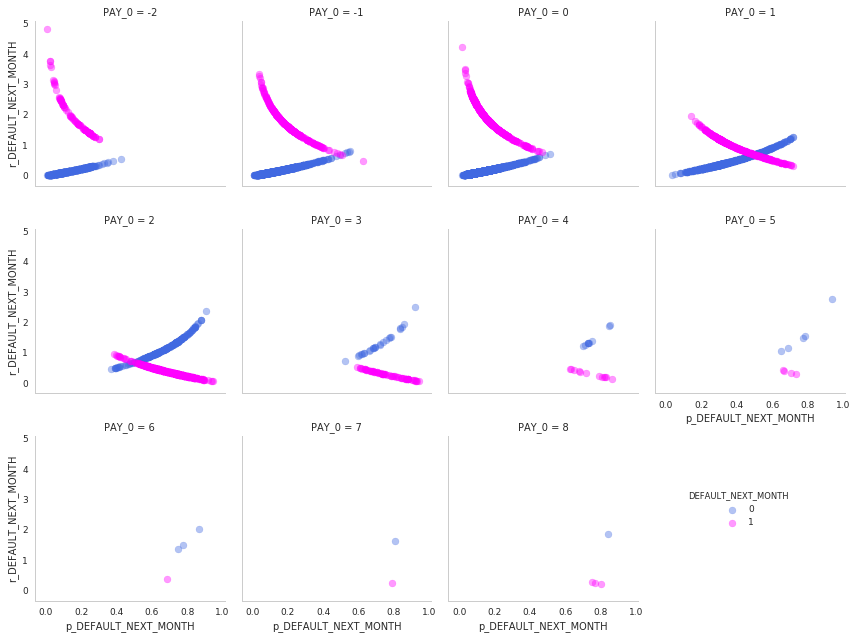

In [12]:
sorted_ = test_yhat.sort_values(by='PAY_0')
sns.set(font_scale=0.9) 
sns.set_style('whitegrid', {'axes.grid': False})
sns.set_palette(sns.color_palette(["#4169e1", "#ff00ff"]))
g = sns.FacetGrid(sorted_, col='PAY_0', hue=y, col_wrap=4)
_ = g.map(plt.scatter, yhat, 'r_DEFAULT_NEXT_MONTH', alpha=0.4)
_ = g.add_legend(loc='lower right', bbox_to_anchor=(0.82, 0.2)) 

`SEX`

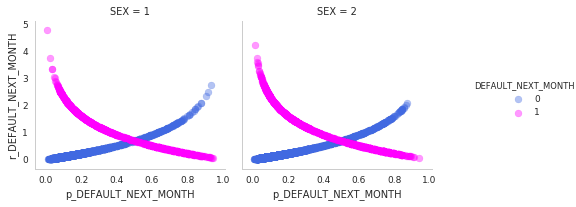

In [13]:
sorted_ = test_yhat.sort_values(by='SEX')
g = sns.FacetGrid(sorted_, col='SEX', hue=y, col_wrap=4)
_ = g.map(plt.scatter, yhat, 'r_DEFAULT_NEXT_MONTH', alpha=0.4)
_ = g.add_legend(bbox_to_anchor=(0.6, 0.5)) 

# 5. Disparate Error Analysis
* `PAY_0`
* `GENDER`

In [14]:
def get_prroc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame
        
prroc_frame = get_prroc(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH')

In [15]:
best_cut = prroc_frame.loc[prroc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1
print('%.2f' % best_cut)

0.25


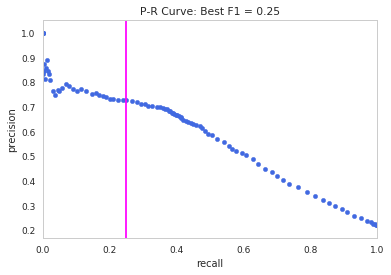

In [16]:
# Plot P-R ROC w/ best cutoff
title_ = 'P-R Curve: Best F1 = ' + str(best_cut)
ax = prroc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='magenta')

In [17]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[i, j] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    
    # output results
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + str(level))
    
    return cm_frame
    
    
get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', cutoff=best_cut)

Confusion matrix:


,actual: 1,actual: 0
predicted: 1,1207,779
predicted: 0,1192,5876


In [18]:
# represent metrics as dictionary for use later
metric_dict = {

#### overall performance
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
#'Adverse Impact': '(tp + fp) / (tp + tn + fp + fn)', # how often the model predicted default for each group   
'Accuracy':       '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity':              'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}    

In [19]:
# small utility function
# translates abbreviated metric expressions into executable Python statements

def cm_exp_parser(expression):
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', '(cm_dict[level].iat[0, 0] + eps)')\
                           .replace('fp', '(cm_dict[level].iat[0, 1] + eps)')\
                           .replace('fn', '(cm_dict[level].iat[1, 0] + eps)')\
                           .replace('tn', '(cm_dict[level].iat[1, 1] + eps)')

    return expression

In [20]:
PAY_0_levels = sorted(list(test_yhat['PAY_0'].unique()))
cm_dict = {}

for level in PAY_0_levels:
    cm_name = '_' + str(level).replace('-', 'm') + '_cm'
    code = cm_name + ''' = get_confusion_matrix(test_yhat,                              
                          "DEFAULT_NEXT_MONTH", 
                          "p_DEFAULT_NEXT_MONTH", 
                          by="PAY_0", 
                          level=level, 
                          cutoff=best_cut)'''
    exec(code)
    exec('cm_dict[level] = ' + cm_name)
 

Confusion matrix by PAY_0=-2
Confusion matrix by PAY_0=-1
Confusion matrix by PAY_0=0
Confusion matrix by PAY_0=1
Confusion matrix by PAY_0=2
Confusion matrix by PAY_0=3
Confusion matrix by PAY_0=4
Confusion matrix by PAY_0=5
Confusion matrix by PAY_0=6
Confusion matrix by PAY_0=7
Confusion matrix by PAY_0=8


In [21]:
metrics_frame = pd.DataFrame(index=PAY_0_levels) # frame for metrics
eps = 1e-20 # for safe numerical operations

# nested loop through:
# - levels
# - metrics 
for level in PAY_0_levels:
    for metric in metric_dict.keys():
              
        # parse metric expressions into executable pandas statements
        expression = cm_exp_parser(metric_dict[metric])
        
        # dynamically evaluate metrics to avoid code duplication
        metrics_frame.loc[level, metric] = eval(expression)  

# display results
metrics_frame = metrics_frame.round(3)
metrics_frame.style.set_caption('Error Metrics for PAY_0')\
                   .background_gradient(cmap=sns.diverging_palette(-20, 260, n=7, as_cmap=True), axis=1)

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
-2,0.049,0.857,0.3,0.119,0.885,0.961,0.115,0.881,0.7,0.039
-1,0.117,0.805,0.383,0.267,0.861,0.913,0.139,0.733,0.617,0.087
0,0.05,0.864,0.345,0.143,0.891,0.963,0.109,0.857,0.655,0.037
1,0.822,0.457,0.368,0.93,0.871,0.229,0.129,0.07,0.632,0.771
2,1,0.709,0.709,1,0.5,0,0.5,0,0.291,1
3,1,0.748,0.748,1,0.5,0,0.5,0,0.252,1
4,1,0.571,0.571,1,0.5,0,0.5,0,0.429,1
5,1,0.444,0.444,1,0.5,0,0.5,0,0.556,1
6,1,0.25,0.25,1,0.5,0,0.5,0,0.75,1
7,1,0.5,0.5,1,0.5,0,0.5,0,0.5,1


In [22]:
SEX_levels = sorted(list(test_yhat['SEX'].unique()))
cm_dict = {}

for level in SEX_levels:
    cm_name = '_' + str(level).replace('-', 'm') + '_cm'
    code = cm_name + ''' = get_confusion_matrix(test_yhat,                              
                          "DEFAULT_NEXT_MONTH", 
                          "p_DEFAULT_NEXT_MONTH", 
                          by="SEX", 
                          level=level, 
                          cutoff=best_cut)'''
    exec(code)
    exec('cm_dict[level] = ' + cm_name)
 

Confusion matrix by SEX=1
Confusion matrix by SEX=2


In [23]:
metrics_frame = pd.DataFrame(index=SEX_levels) # frame for metrics
eps = 1e-20 # for safe numerical operations

# nested loop through:
# - levels
# - metrics 
for level in SEX_levels:
    for metric in metric_dict.keys():
              
        # parse metric expressions into executable pandas statements
        expression = cm_exp_parser(metric_dict[metric])
        
        # dynamically evaluate metrics to avoid code duplication
        metrics_frame.loc[level, metric] = eval(expression)  

# display results
metrics_frame = metrics_frame.round(3)
metrics_frame.style.set_caption('Error Metrics for SEX')\
                   .background_gradient(cmap=sns.diverging_palette(-20, 260, n=7, as_cmap=True), axis=1)

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
1,0.3,0.773,0.513,0.655,0.884,0.809,0.116,0.345,0.487,0.191
2,0.242,0.788,0.495,0.573,0.882,0.845,0.118,0.427,0.505,0.155


***
* **Accuracy concerns:** Do high-residual individual's share any traits? 
* **Fairness concerns:** Do high-residual individual's share any *protected* traits?
* **Security concerns:** Are any high-residual individuals using watermarks or backdoors to attack the classifier? People who got the loan? Are any of these people employees or contractors? Did any employees get a loan? 
* Any patterns in the residuals? Can they be modeled out using external data? Are they associated with any protected variables? Are they potential security concerns?
* Does overall pattern of residuals indicate any sociological bias or data poisoning?

# 6. Benchmark Models

***
* monitor in real-time, difference from benchmark could be adversary or fairness issue

# 7. Explanations of Residuals

### 7.1 Shapley Values for Predictions and Residuals

In [24]:
# init explainer object for access to explainer.expected_value() function below
explainer = shap.TreeExplainer(xgb_model, test_yhat[X], feature_dependence='independent', model_output='logloss')

# load if pre-calculated
if os.path.isfile('shap_error_values.csv'):
    
    shap_values = np.loadtxt('shap_error_values.csv', delimiter=',') # load
    print('Pre-calculated Shapley values loaded from disk.')         # print confirmation

# else, calculate
else: 
    
    xgb_model.set_attr(objective='binary:logistic')
    shap_values = explainer.shap_values(test_yhat[X], y=test_yhat[y])  # long step (hours!)
    np.savetxt('shap_error_values.csv', shap_values, delimiter=',')    # save for immediate reuse later
    

Pre-calculated Shapley values loaded from disk.


#### Plot Shapley value summary for global importance measure in prediction and residuals
* calculate pred importance
* two-pane plot

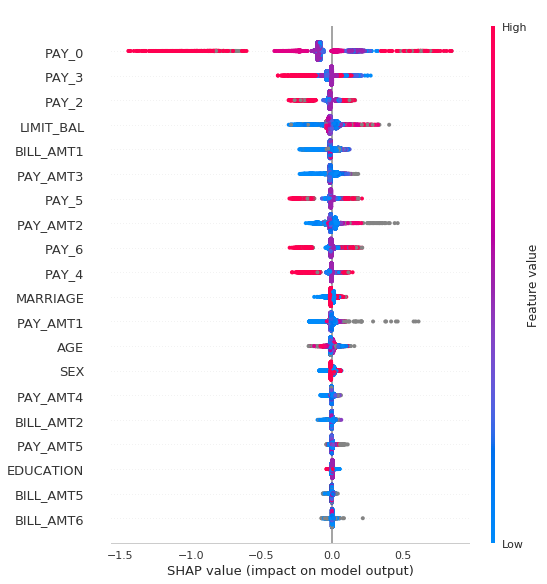

In [25]:
shap.summary_plot(shap_values[:, :-1], test_yhat[xgb_model.feature_names])

***
* Compare to Shap of predictions ^^^ - can variables that are out of order be removed?

#### Residuals vs. local Shapley prediction values
* `PAY_0`
* `GENDER`

***
* can we set these variables to missing/mean for high residual groups based on shapley contribution? Any odd patterns that could be indicative of data poisoning?
* are protected variable contributions much different?

#### Mean Shapley contributions of high and low residual customers

***
* Which variables are associated with residuals for high group? What if they are set to missing, mean?

#### Shapley contributions to logloss for a specific individual
* Locate highest residual individual - pick person who should have been rejected but wasn't

In [26]:
row_id = test_yhat_sorted.loc[0, 'ID']
row = test_yhat[test_yhat['ID'] == row_id]

# reset test data index to find riskiest customer in shap_values 
# sort to find largest positive contributions
s_df = pd.DataFrame(shap_values[row.index[0], :].reshape(23, 1), columns=['Loss Contribs'], index=X)
s_df.sort_values(by='Loss Contribs', inplace=True, ascending=False)
s_df['Loss Contribs']

PAY_AMT1     0.611533
LIMIT_BAL    0.403705
PAY_AMT2     0.352150
PAY_0        0.311651
PAY_3        0.272713
PAY_AMT3     0.184478
PAY_6        0.147152
PAY_2        0.128540
BILL_AMT1    0.123718
MARRIAGE     0.100163
PAY_5        0.092106
PAY_AMT5     0.086318
PAY_AMT6     0.075505
PAY_4        0.067393
BILL_AMT2    0.064727
EDUCATION    0.051236
PAY_AMT4     0.046066
BILL_AMT4    0.022856
BILL_AMT6    0.011413
BILL_AMT5    0.006382
BILL_AMT3    0.000471
AGE         -0.050907
SEX         -0.073163
Name: Loss Contribs, dtype: float64

In [27]:
# should match residual value for row ... very close
print('Total Shapley contributions: %.6f' % (s_df['Loss Contribs'].sum() + explainer.expected_value(row[y].values[0])))

Total Shapley contributions: 4.826473


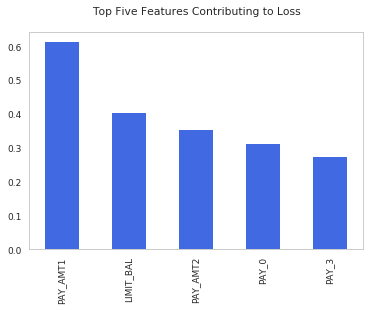

In [28]:
_ = s_df[:5].plot(kind='bar', 
                  title='Top Five Features Contributing to Loss\n', 
                  legend=False)

In [29]:
row # helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
300,983,500000,1,1,2,36,-2,-2,-2,-2,-2,-2,45106,81264,18122,27229,21462,27911,81690,18225,27365,21570,28050,17397,1,0.008015,4.826454


For this individual the top five characteristics contributing to the logloss residual are:
* Most recent payment is NT dollar 81,690 (high)
* Credit limit is NT dollar 500,000 (high)
* Second most recent payment NT dollar 18,225 (high)
* Most recent repayment status is `PAID IN FULL` (very good)
* Third most recent repayment status is `PAID IN FULL` (very good)

***
* are there any security concerns or does the pattern seem ok compared to results above?
* look for adversarial attacks? Weird contributions and variable values.
* any protected variables playing into error heavily

### 7.2  Explain LogLoss Residuals with Surrogate Decision Trees

#### Use H2O to train surrogate decision trees on each class of residuals

In [30]:
import h2o    
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree

h2o.init()

# utility function to train surrogate DTs
def train_cv_surrogate_dt(model_id, X, yhat, frame):
                                          
    # initialize single tree surrogate model
    surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                         sample_rate=1,     # use all rows in that tree
                                         mtries=-2,         # use all columns in that tree
                                         max_depth=4,       # shallow trees are easier to understand
                                         seed=12345,        # random seed for reproducibility
                                         nfolds=3,
                                         model_id=model_id) # gives MOJO artifact a recognizable name

    # train single tree surrogate model
    surrogate.train(x=X, y=yhat, training_frame=h2o.H2OFrame(frame))

    # persist MOJO (compiled, representation of trained model)
    # from which to generate plot of surrogate
    mojo_path = surrogate.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)
    
    return mojo_path, surrogate
    
mojo_path0, surrogate0 = train_cv_surrogate_dt('surrogate0', X, 'r_DEFAULT_NEXT_MONTH', test_yhat[test_yhat[y] == 0])                                     
mojo_path1, surrogate1 = train_cv_surrogate_dt('surrogate1', X, 'r_DEFAULT_NEXT_MONTH', test_yhat[test_yhat[y] == 1])  

h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_201"; Java(TM) SE Runtime Environment (build 1.8.0_201-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcl5a9kds
  JVM stdout: /tmp/tmpcl5a9kds/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpcl5a9kds/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,3 months and 6 days
H2O cluster name:,H2O_from_python_patrickh_wkxlae
H2O cluster total nodes:,1
H2O cluster free memory:,3.422 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/interpretable_machine_learning_with_python/surrogate0.zip
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/interpretable_machine_learning_with_python/surrogate1.zip
H2O session _sid_8d95 closed.


#### Display error measures to ensure trustworthiness of surrogate models

In [31]:
# for DEFAULT_NEXT_MONTH = 0
surrogate0.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.055455755,0.0013651234,0.052755732,0.057156604,0.056454934
1,mean_residual_deviance,0.006993064,2.8336645E-4,0.006517125,0.0074974936,0.0069645736
2,mse,0.006993064,2.8336645E-4,0.006517125,0.0074974936,0.0069645736
3,r2,0.88753355,0.0072556557,0.8943817,0.8730297,0.8951892
4,residual_deviance,0.006993064,2.8336645E-4,0.006517125,0.0074974936,0.0069645736
5,rmse,0.08359027,0.0016928223,0.08072871,0.08658807,0.08345402
6,rmsle,0.0591188,0.001497812,0.05636424,0.061515696,0.059476465


In [32]:
# for DEFAULT_NEXT_MONTH = 1

In [33]:
surrogate1.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.16745956,0.002118648,0.16916788,0.16324724,0.16996355
1,mean_residual_deviance,0.0674532,0.00211074,0.06981851,0.069298685,0.063242406
2,mse,0.0674532,0.00211074,0.06981851,0.069298685,0.063242406
3,r2,0.88707805,0.004928338,0.8798821,0.8848426,0.89650947
4,residual_deviance,0.0674532,0.00211074,0.06981851,0.069298685,0.063242406
5,rmse,0.25965294,0.004096145,0.26423192,0.26324642,0.25148043
6,rmsle,0.099633954,0.0020928653,0.103740685,0.09828153,0.09687965


#### Create graphviz `.dot` file for visualizing surrogate decision tree

In [34]:
from h2o.backend import H2OLocalServer # for plotting local tree in-notebook
import subprocess                      # manage external processes

# utility function to generate graphviz dot file from h2o mojo
def get_gv(title, model_id, mojo_path):

    # locate h2o jar
    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    # construct command line call to generate graphviz version of 
    # surrogate tree see for more information: 
    # http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    gv_file_name = model_id + '.gv'
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + mojo_path + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', title]
    
    # call 
    print()
    print('Calling external process ...')
    print(' '.join(gv_args))
    _ = subprocess.call(gv_args)
    
get_gv('LogLoss Residual Surrogate (DEFAULT_NEXT_MONTH=0)', 'surrogate0', mojo_path0)
get_gv('LogLoss Residual Surrogate (DEFAULT_NEXT_MONTH=1)', 'surrogate1', mojo_path1)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/interpretable_machine_learning_with_python/surrogate0.zip -o surrogate0.gv --title LogLoss Residual Surrogate (DEFAULT_NEXT_MONTH=0)
Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/interpretable_machine_learning_with_python/surrogate1.zip -o surrogate1.gv --title LogLoss Residual Surrogate (DEFAULT_NEXT_MONTH=1)


#### Convert `.dot` files into `.png`s

In [35]:
# utility function to generate pngs from dots
def get_png(model_id):

    gv_file_name = model_id + '.gv'
    
    # construct call to generate PNG from 
    # graphviz representation of the tree
    png_file_name = model_id + '.png'
    png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
    png_args = png_args.split()

    # call
    print('Calling external process ...')
    print(' '.join(png_args))
    _ = subprocess.call(png_args)
    
get_png('surrogate0')
get_png('surrogate1')

Calling external process ...
dot -Tpng surrogate0.gv -o surrogate0.png
Calling external process ...
dot -Tpng surrogate1.gv -o surrogate1.png


#### Surrogate decision tree for `DEFAULT_NEXT_MONTH` = 0 logloss residuals

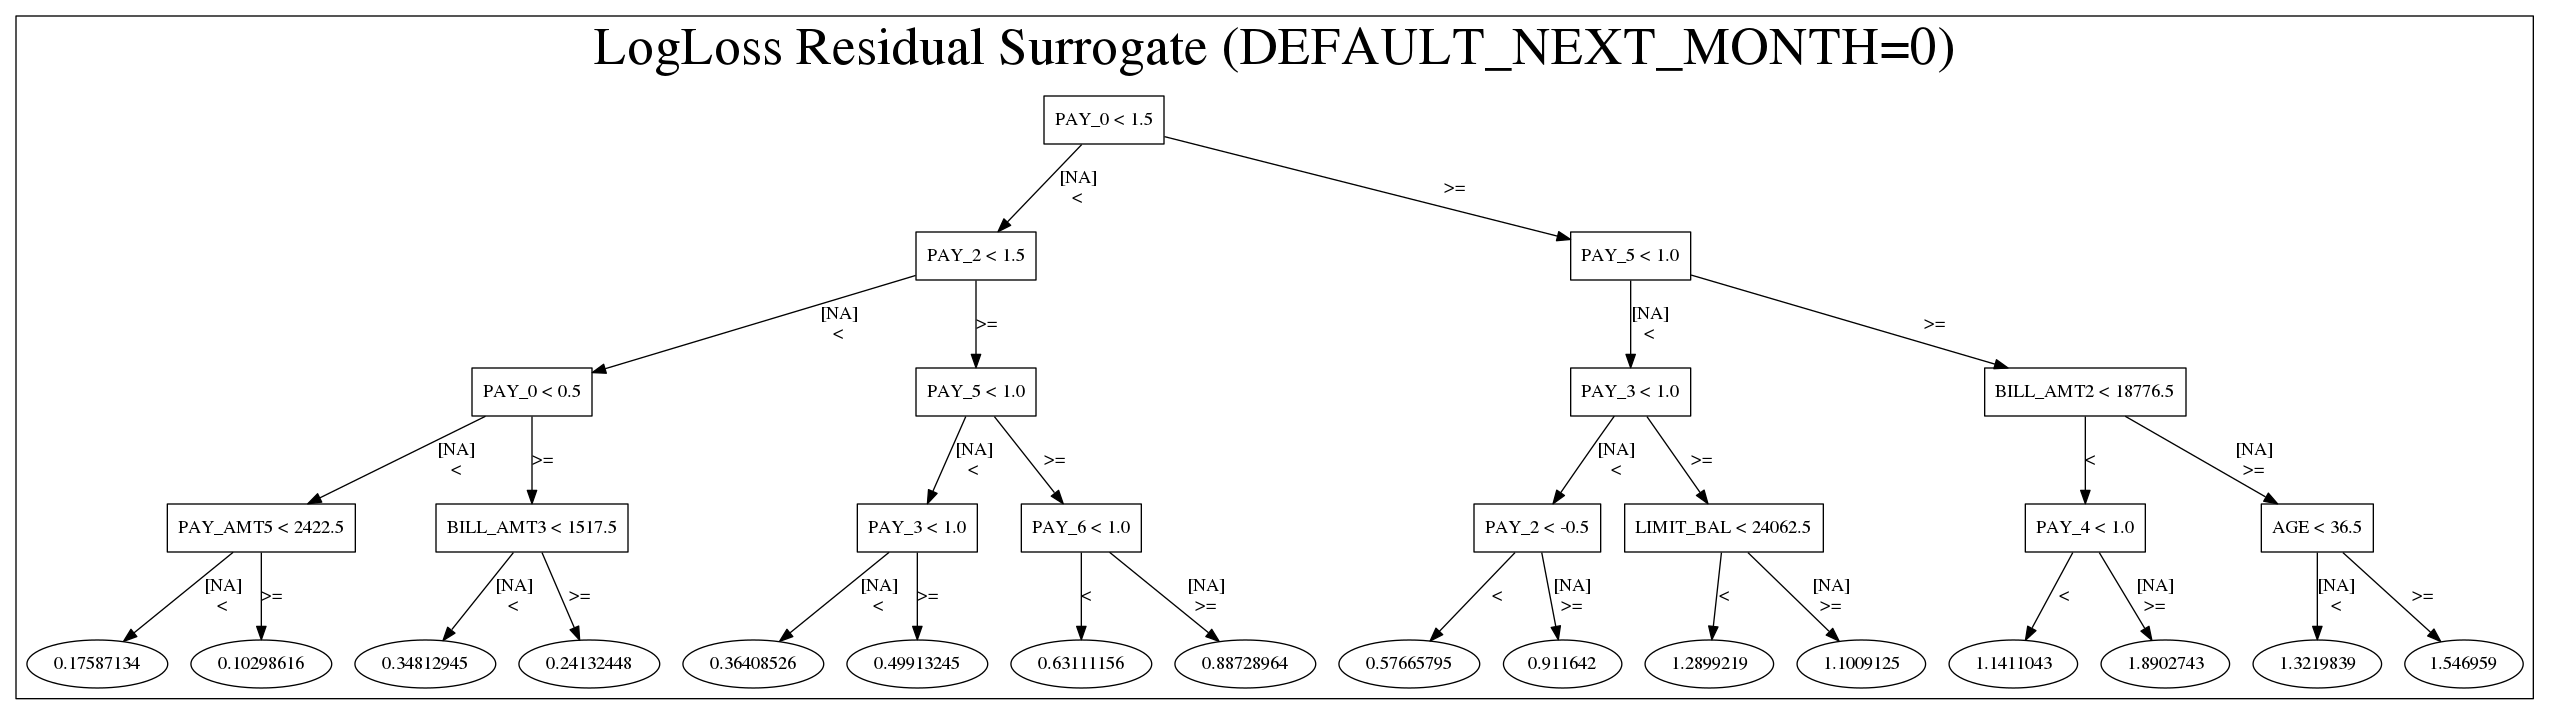

In [36]:
# display in-notebook
display(Image(('surrogate0.png')))

#### Surrogate decision tree for `DEFAULT_NEXT_MONTH` = 1 logloss residuals

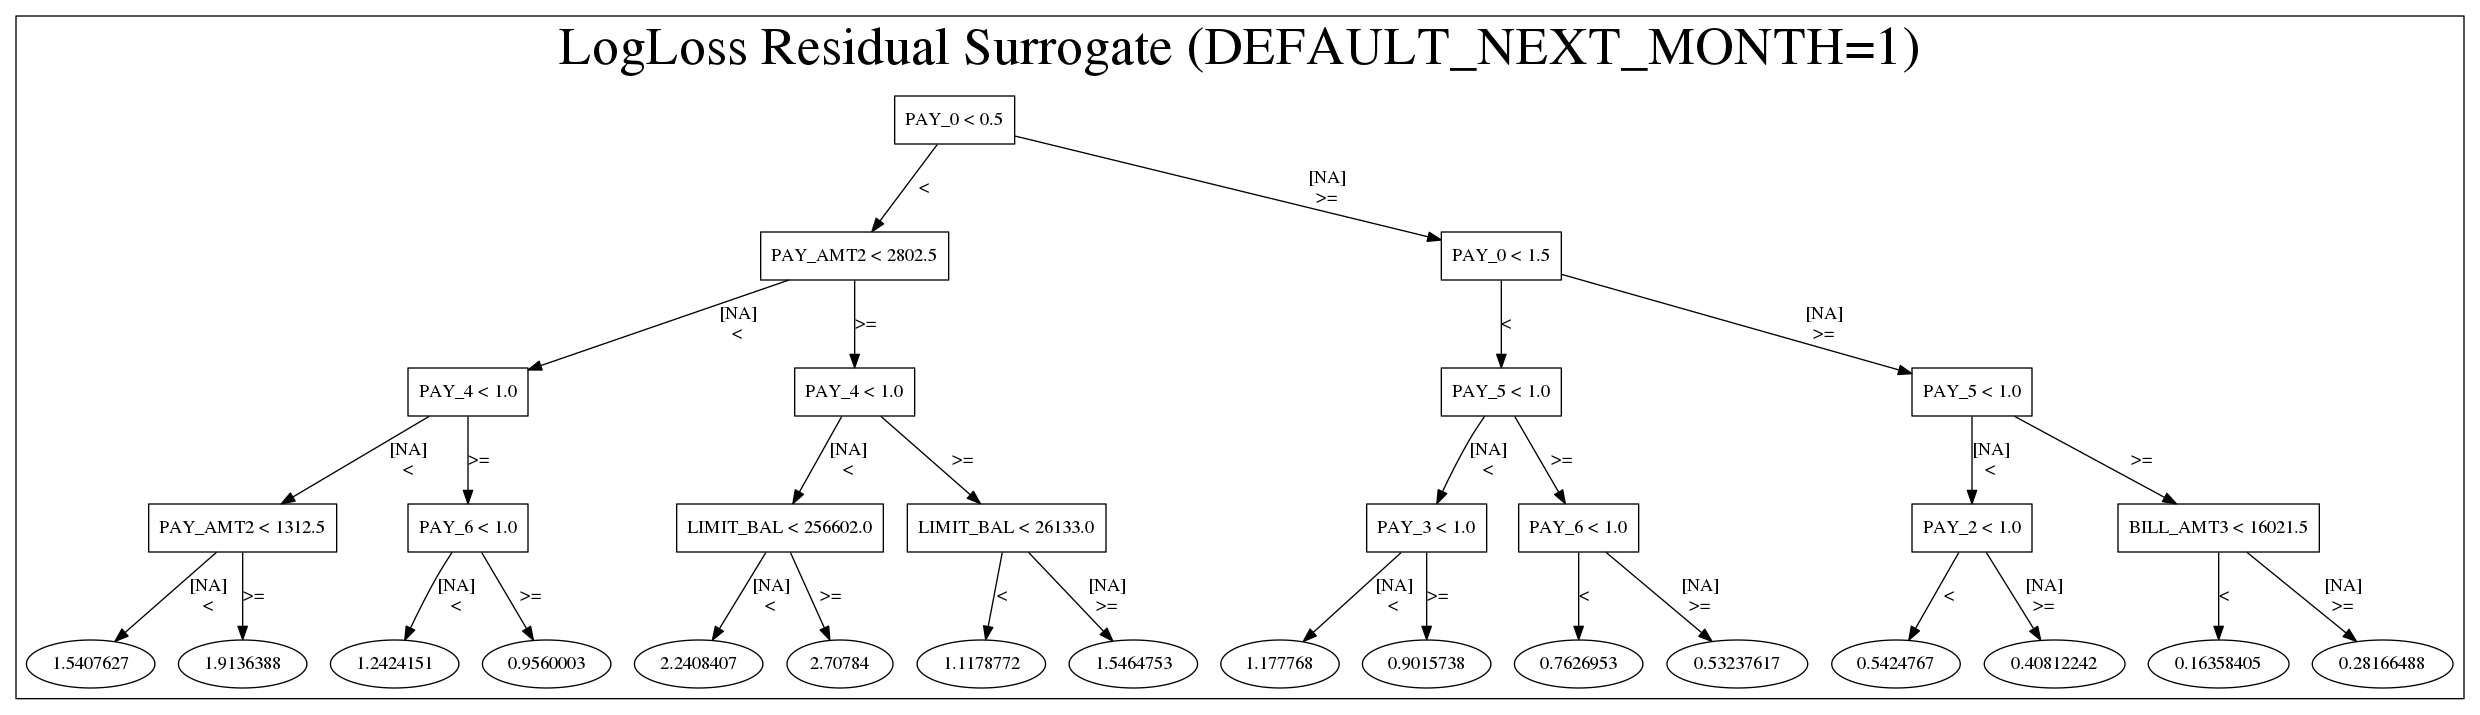

In [37]:
# display in-notebook
display(Image(('surrogate1.png')))

***
* The decision tree model and rules represent global error mechanisms. Can actions be taken based on these findings to remediate model errors? 
* Do these patterns pose any concerns from fairness or security perspective?

#### Conclusion
Now that we can indentify global and local error mechanisms, can we:  
* Study the error mechanisms and make manual changes to address them? 
* Train models or learn rules on what is driving error and take corrective action automatically during training or after?
* Boosting by row and variable?
* First steps toward self-healing models?
* Use explanation of residuals: DT surrogate, Shap to automatically build tests/assertions/adversaries?